## This notebook calculates the following metrics sourced from Cal-Adapt Tools: Wildfire
* Change in total area burned per tract per year

In [1]:
import pandas as pd
import os
import sys
import math
import geopandas as gpd
import xarray as xr
import cftime

import pyproj
import rioxarray as rio
import xarray as xr

# projection information
import cartopy.crs as ccrs

# suppress pandas purely educational warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import upload_csv_aws, filter_counties
from scripts.utils.write_metadata import append_metadata

In [4]:
def process_fire_data(fn):
    bucket_loc = "s3://ca-climate-index/1_pull_data/climate_risk/wildfire/loss/projections/caladapt/"
    filepath = bucket_loc + fn + "_AA.monthly_all.bau.mu.nc.zarr"
    print('Opening: {}'.format(filepath))
    ds = xr.open_dataset(
        filepath, 
        engine="zarr",
        consolidated=False,
        decode_times=False
    )    
    units, refdate = ds.time.attrs['units'].split('since')
    ds['time'] = pd.date_range(start=refdate, periods=ds.sizes['time'], freq='MS')

    # calculate annual area burned
    print('Calculating annual sum of area burned...')
    ds = ds.resample(time='1Y').sum()
    return ds

def convert_30yr(start):
    return (start-5, start+24)

In [5]:
# this takes a few minutes because it is opening the file and then pre-processing by calculating the annual sum
# approx 2 min  per file
# RCP 4.5
miroc45 = process_fire_data(fn='MIROC5_45')
cnrm45 = process_fire_data(fn='CNRM-CM5_45')
hadgem45 = process_fire_data(fn='HadGEM2-ES_45')
canesm45 = process_fire_data(fn='CanESM2_45')

# RCP 8.5
miroc85 = process_fire_data(fn='MIROC5_85')
cnrm85 = process_fire_data(fn='CNRM-CM5_85')
hadgem85 = process_fire_data(fn='HadGEM2-ES_85')
canesm85 = process_fire_data(fn='CanESM2_85')

Opening: s3://ca-climate-index/1_pull_data/climate_risk/wildfire/loss/projections/caladapt/MIROC5_45_AA.monthly_all.bau.mu.nc.zarr
Calculating annual sum of area burned...
Opening: s3://ca-climate-index/1_pull_data/climate_risk/wildfire/loss/projections/caladapt/CNRM-CM5_45_AA.monthly_all.bau.mu.nc.zarr
Calculating annual sum of area burned...
Opening: s3://ca-climate-index/1_pull_data/climate_risk/wildfire/loss/projections/caladapt/HadGEM2-ES_45_AA.monthly_all.bau.mu.nc.zarr
Calculating annual sum of area burned...
Opening: s3://ca-climate-index/1_pull_data/climate_risk/wildfire/loss/projections/caladapt/CanESM2_45_AA.monthly_all.bau.mu.nc.zarr
Calculating annual sum of area burned...
Opening: s3://ca-climate-index/1_pull_data/climate_risk/wildfire/loss/projections/caladapt/MIROC5_85_AA.monthly_all.bau.mu.nc.zarr
Calculating annual sum of area burned...
Opening: s3://ca-climate-index/1_pull_data/climate_risk/wildfire/loss/projections/caladapt/CNRM-CM5_85_AA.monthly_all.bau.mu.nc.zarr


#### Step 1a) Calculate historical baseline (1981-2010)

In [6]:
# grab historical period in each, and take multimodel mean
all_sims = [miroc45, miroc85, cnrm45, cnrm85, hadgem45, hadgem85, canesm45, canesm85]

ds_hist = xr.concat(all_sims, 'simulation')
ds_hist = ds_hist.sel(time=slice('1981', '2010')).mean(dim='time').mean(dim='simulation') # subset for historical baseline period, and take multi-model mean

In [7]:
ds_hist.hectares.min(), ds_hist.hectares.max(), ds_hist.hectares.mean()

(<xarray.DataArray 'hectares' ()>
 array(0.),
 <xarray.DataArray 'hectares' ()>
 array(72.98579407),
 <xarray.DataArray 'hectares' ()>
 array(5.905063, dtype=float32))

In [8]:
# somewhat low? looking into each model -- 
def test_historical(ds):
    ds_sub = ds.sel(time=slice('1981','2010')).mean(dim='time')
    print(ds_sub.hectares.min(), ds_sub.hectares.max())

for mdl in all_sims:
    test_historical(mdl)

<xarray.DataArray 'hectares' ()>
array(0.) <xarray.DataArray 'hectares' ()>
array(72.82633209)
<xarray.DataArray 'hectares' ()>
array(0.) <xarray.DataArray 'hectares' ()>
array(70.47467804)
<xarray.DataArray 'hectares' ()>
array(0.) <xarray.DataArray 'hectares' ()>
array(75.83365631)
<xarray.DataArray 'hectares' ()>
array(0.) <xarray.DataArray 'hectares' ()>
array(75.75833893)
<xarray.DataArray 'hectares' ()>
array(0.) <xarray.DataArray 'hectares' ()>
array(71.63867188)
<xarray.DataArray 'hectares' ()>
array(0.) <xarray.DataArray 'hectares' ()>
array(80.78733826)
<xarray.DataArray 'hectares' ()>
array(0.) <xarray.DataArray 'hectares' ()>
array(80.18798065)
<xarray.DataArray 'hectares' ()>
array(0.) <xarray.DataArray 'hectares' ()>
array(82.21967316)


#### Step 1b) Calculate warming level per model
This will have to be manually done per model
* https://github.com/mathause/cmip_warming_levels/blob/main/warming_levels/cmip5_all_ens/csv/cmip5_warming_levels_all_ens_1850_1900_no_bounds_check.csv
* Assuming all models are r1i1ip1f1
* The csv file at loc above has typos in it, making it unreadable programmatically -- working manually
   * uses a 20 year average around start year
   * MIROC5 4.5 -- 2063-2082, MIROC5 8.5 -- 2039-2058
   * CNRM-CM5 4.5 -- 2049-2068, CNRM-CM5 8.5 -- 2036-2055
   * HADGEM-ES 4.5 -- 2034-2053, HADGEM-ES 8.5 -- 2026-2045
   * CANESM2 4.5 -- 2022-2041, CANESM2 8.5 -- 2017-2036

In [9]:
sim_yrs = {
    'miroc45'  : 2063,
    'miroc85'  : 2039,
    'cnrm45'   : 2049,
    'cnrm85'   : 2036,
    'hadgem45' : 2034,
    'hadgem85' : 2026,
    'canesm45' : 2022,
    'canesm85' : 2017
}

for i in sim_yrs.keys():
    print(i, '20-yr-start: ', sim_yrs.get(i), '30-yr range:', convert_30yr(sim_yrs.get(i)))

miroc45 20-yr-start:  2063 30-yr range: (2058, 2087)
miroc85 20-yr-start:  2039 30-yr range: (2034, 2063)
cnrm45 20-yr-start:  2049 30-yr range: (2044, 2073)
cnrm85 20-yr-start:  2036 30-yr range: (2031, 2060)
hadgem45 20-yr-start:  2034 30-yr range: (2029, 2058)
hadgem85 20-yr-start:  2026 30-yr range: (2021, 2050)
canesm45 20-yr-start:  2022 30-yr range: (2017, 2046)
canesm85 20-yr-start:  2017 30-yr range: (2012, 2041)


In [10]:
## brute force calculating for the time being
miroc45_wl = miroc45.sel(time=slice('2058', '2087')).mean(dim='time')
cnrm45_wl = cnrm45.sel(time=slice('2044', '2073')).mean(dim='time')
hadgem45_wl = hadgem45.sel(time=slice('2029', '2058')).mean(dim='time')
canesm45_wl = canesm45.sel(time=slice('2017', '2046')).mean(dim='time')

# RCP 8.5
miroc85_wl = miroc85.sel(time=slice('2034', '2063')).mean(dim='time')
cnrm85_wl = cnrm85.sel(time=slice('2031', '2060')).mean(dim='time')
hadgem85_wl = hadgem85.sel(time=slice('2021', '2050')).mean(dim='time')
canesm85_wl = canesm85.sel(time=slice('2012', '2041')).mean(dim='time')

projs = [miroc45_wl, miroc85_wl, cnrm45_wl, cnrm85_wl, hadgem45_wl, hadgem85_wl, canesm45_wl, canesm85_wl]
ds_proj = xr.concat(projs,'simulation')
ds_proj = ds_proj.mean(dim='simulation')
ds_proj

<xarray.Dataset>
Dimensions:   (lat: 179, lon: 173)
Coordinates:
  * lat       (lat) float64 31.59 31.66 31.72 31.78 ... 42.53 42.59 42.66 42.72
  * lon       (lon) float64 -124.5 -124.5 -124.4 -124.3 ... -113.9 -113.8 -113.8
Data variables:
    hectares  (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

#### Step 2: Calculate delta signal

In [11]:
ds_delta = ds_proj - ds_hist

#### Step 3: Reproject data to census tract projection

In [12]:
# read in CA census tiger file -- not working from s3 link, uploading manually to keep testing
census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"
ca_boundaries = gpd.read_file(census_shp_dir)

# # need to rename columns so we don't have any duplicates in the final geodatabase
column_names = ca_boundaries.columns
new_column_names = ["USCB_"+column for column in column_names if column != "geometry"]
ca_boundaries = ca_boundaries.rename(columns=dict(zip(column_names, new_column_names)))
ca_boundaries = ca_boundaries.to_crs(crs=3857) 

In [13]:
df = ds_delta.to_dataframe().reset_index()
df

,lat,lon,hectares
0,31.59375,-124.53125,0.0
1,31.59375,-124.46875,0.0
2,31.59375,-124.40625,0.0
3,31.59375,-124.34375,0.0
4,31.59375,-124.28125,0.0
...,...,...,...
30962,42.71875,-114.03125,0.0
30963,42.71875,-113.96875,0.0
30964,42.71875,-113.90625,0.0
30965,42.71875,-113.84375,0.0


In [14]:
df.hectares.min(), df.hectares.max()

(-35.910457611083984, 123.4852066040039)

In [15]:
# taking about 2 min
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon,df.lat), crs="EPSG:4326")
gdf = gdf.to_crs(ca_boundaries.crs)

# clipped_gdf = clipped_gdf.set_index(['USCB_GEOID'])
ca_boundaries = ca_boundaries.set_index(['USCB_GEOID'])
clipped_gdf = gpd.sjoin_nearest(ca_boundaries, gdf, how='left')
clipped_gdf = clipped_gdf[["geometry","hectares"]]

diss_gdf = clipped_gdf.reset_index().dissolve(by='USCB_GEOID', aggfunc='mean')

In [16]:
diss_gdf.hectares.min(), diss_gdf.hectares.max()

(-35.910457611083984, 53.45079040527344)

<Axes: >

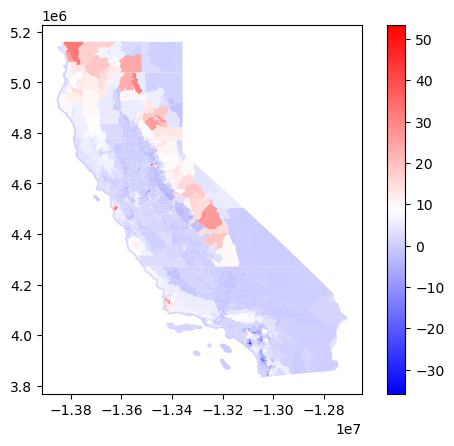

In [17]:
diss_gdf.plot(column='hectares', cmap='bwr', legend=True)

#### Step 4: Min-max standardization
Using Cal-CRAI min-max standardization function, available in `utils.calculate_index.py`

In [18]:
def min_max_standardize(df, cols_to_run_on):
    '''
    Calculates min and max values for specified columns, then calculates
    min-max standardized values.

    Parameters
    ----------
    df: DataFrame
        Input dataframe   
    cols_to_run_on: list
        List of columns to calculate min, max, and standardize
    '''
    for col in cols_to_run_on:
        max_value = df[col].max()
        min_value = df[col].min()

        # Get min-max values, standardize, and add columns to df
        prefix = col # Extracting the prefix from the column name
        df[f'{prefix}_min'] = min_value
        df[f'{prefix}_max'] = max_value
        df[f'{prefix}_min_max_standardized'] = ((df[col] - min_value) / (max_value - min_value))
        
        # note to add checker to make sure new min_max column values arent < 0 >
        
        # Drop the original columns
        # df.drop(columns=[col], inplace=True)
     
    return df

In [19]:
data_std = min_max_standardize(diss_gdf, cols_to_run_on=['hectares'])

# drop geometry column
data_std = data_std.drop(columns = ['geometry'])

#### Step 5: Export data as csv

In [20]:
data_std.to_csv('climate_wildfire_burned_area_metric.csv')

#### Step 6: Metadata

In [21]:
@append_metadata
def wildfire_burned_area_metadata(df, export=False, export_filename=None, varname=''):
    '''
    Transforms the raw data into the following baseline metrics:
    * Change in total area burned per tract per year
    
    Methods
    -------
    Data is natively modeled area burned
    Uses CMIP5 warming level targets identified from: 
    https://github.com/mathause/cmip_warming_levels/blob/main/warming_levels/cmip5_all_ens/csv/cmip5_warming_levels_all_ens_1850_1900_no_bounds_check.csv
    
    Parameters
    ----------
    df: pd.DataFrame
        Input data.
    export: True/False boolean
        False = will not upload resulting df containing CAL CRAI wildfire burn area metric to AWS
        True = will upload resulting df containing CAL CRAI wildfire burn area metric to AWS
    export_filename: string
        name of csv file to be uploaded to AWS
    varname: string
        Final metric name, for metadata generation
        
    Script
    ------
    climate_area_burned.ipynb
    '''
    print('Data transformation: monthly # of hectares summed to annual counts per model.')
          
    # historical baseline
    print("Data transformation: historical baseline data subsetted for 1981-2010, averaging across models.")
    
    # calculate with 2°C WL
    print('Data transformation: data subsetted for warming level of 2.0°C, by manually subsetting based on GWL for parent GCM, and calculating 30 year average, averaging across models.')

    # calculate delta signal
    print("Data transformation: delta signal calculated by taking difference between chronic (2.0°C) and historical baseline.")

    # reprojection to census tracts
    print("Data transformation: data transformed from xarray dataset into pandas dataframe.")
    print("Data transformation: data reprojected from Lambert Conformal Conic CRS to CRS 3857.")
        
    # min-max standardization
    print("Data transformation: data min-max standardized with min_max_standardize function.")
    
    # export data as csv
    if export == True:
        bucket_name = 'ca-climate-index'
        directory = '3_fair_data/index_data'
        export_filename = [export_filename]
        upload_csv_aws(export_filename, bucket_name, directory)
        
        # # Check if file exists before attempting to remove it
        # if os.path.exists('climate_wildfire_burned_area_metric.csv'):
        #     os.remove('climate_wildfire_burned_area_metric') # remove from local to clear up directory
        
        # if os.path.exists(export_filename[0]):
        #     os.remove(export_filename[0])
    
    if export == False:
        print(f'{export_filename} uploaded to AWS.')

In [22]:
wildfire_burned_area_metadata(data_std, export=False, export_filename ='climate_wildfire_burned_area_metric.csv', varname='test') # varname)